# Summer Roadtrip

**Project Description**

Generate a roadtrip route through the most picturesque and popular landmarks and natural attractions. Use available data (e.g., photo frequency, reviews) to rank stops and suggest how long to spend at each.

- Build a route display with a map and scrollable landmark cards.
- Create a visual layout highlighting landmark photos and descriptions.
- Add filtering or sorting by popularity, type (e.g., “nature,” “architecture”), or time required.
- Display total trip summary (e.g., distance, number of stops).

In [83]:
import pandas as pd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from haversine import haversine

import itertools
import math

from geopy.geocoders import Nominatim

## Find and Prepare Data

Collect data on locations;
- Must contain longitude and latitude
- Location name
- Select a maximum of 9 locations to find the optimal route in a reasonable time
- Some datasets on Kaggle

We decided to work with 5 nationally recognizable landmarks for our sightseeing project. We manually collected the data from web searches on Google.

In [8]:
# Link to read the data in Sabrina's branch
url = 'https://raw.githubusercontent.com/KRMalaGrino/butterfly-brigade/refs/heads/sabrina/data_science/Landmark_Dataset_with_Visit_Time_and_Popularity_Factors.csv'
df = pd.read_csv(url)

In [10]:
# View the data 
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,Grand Canyon Village,Arizona,Grand Canyon,36.1069,-112.1129,Natural,8,4.9,60000,6000000
2,Niagara Falls,New York,Niagara Falls,43.0962,-79.0377,Natural,4,4.8,55000,9000000
3,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
4,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
5,Washington,District of Columbia,Lincoln Memorial,38.8893,-77.0502,Historical,1,4.8,25000,8000000
6,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
7,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000
8,Las Vegas,Nevada,Las Vegas Sphere,36.1699,-115.1398,Architectural/Entertainment,2,4.6,10000,3000000


In [12]:
# Reduce  list to only 5 locations and reset the index
df = df.drop(index=[1, 2, 5, 8], errors='ignore').reset_index(drop=True)

In [14]:
# Check the changes
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
2,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
3,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
4,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000


In [16]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 5 non-null      object 
 1   State                5 non-null      object 
 2   Landmark             5 non-null      object 
 3   Latitude             5 non-null      float64
 4   Longitude            5 non-null      float64
 5   Type                 5 non-null      object 
 6   Visit Time (hrs)     5 non-null      int64  
 7   Average User Rating  5 non-null      float64
 8   Reviews/Photos       5 non-null      int64  
 9   Annual Visitors      5 non-null      int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 532.0+ bytes


In [18]:
# Lower case the columns and fill whitespace with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

In [20]:
# Check changes
df.columns

Index(['city', 'state', 'landmark', 'latitude', 'longitude', 'type',
       'visit_time_(hrs)', 'average_user_rating', 'reviews_photos',
       'annual_visitors'],
      dtype='object')

In [22]:
# Lowercase the values, replace whitespace and / with an underscore
df = df.map(lambda x: x.lower().replace(' ', '_').replace('/', '_') if isinstance(x, str) else x)

In [24]:
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000


### Feature Engineering

To summarize the average_user_rating, review_photos and annual_vistors, we are creating an additional feature to score overall 'popularity' for each landmark.

In [28]:
# Set the weights to value the degree of importance of each of the columns
w_r = 0.40 # weight for the ratings
w_p = 0.30 # weight for the reviews_photos
w_v = 0.30 # weight for the visitors

In [30]:
# Calculate max values 
max_reviews = df['reviews_photos'].max()
max_visitors = df['annual_visitors'].max()

In [32]:
# Feature engineering to score popularity out of 100
df['rating_factor'] = (df['average_user_rating'] / 5) * 100
df['reviews_factor'] = (df['reviews_photos'] / max_reviews) * 100
df['visitors_factor'] = (df['annual_visitors'] / max_visitors) * 100

In [34]:
# Calculate Popularity Score
df['popularity'] = (
    (df['rating_factor'] * w_r) +
    (df['reviews_factor'] * w_p) +
    (df['visitors_factor'] * w_v)
)

In [36]:
# Check changes
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47.458012
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50.412373
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,43.928600
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59.454767
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,97.600000


In [38]:
# Round the 'popularity' score up to a whole number and change the type to integer
df['popularity'] = df['popularity'].round(0).astype(int)
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,44
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,98


### Visualizations

**Top 5 Popular Landmarks**

This visualization highlights which landmarks are most popular.

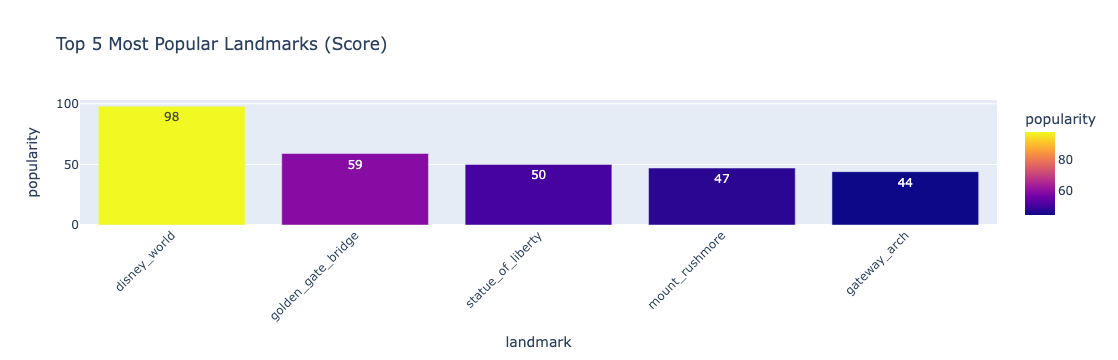

In [43]:
# Get the top 5 landmarks based on popularity score
top10 = df.sort_values(by='popularity', ascending=False).head(10)

# Create a bar chart
fig = px.bar(
    top10,
    x='landmark', # landmark names on x-axis
    y='popularity', # popularity score on y-axis
    color='popularity', # color code based on the score
    title='Top 5 Most Popular Landmarks (Score)',
    hover_data=['city', 'state', 'visit_time_(hrs)'], # show details on the hover
    text='popularity' # show scores as text on the bars
)

fig.update_layout(xaxis_tickangle=-45) # rotate text on x-axis

fig.show() # display the chart

**Map Route for Visiting Most Popular Destinations in Order**

This map helps visualize the route based on geography.

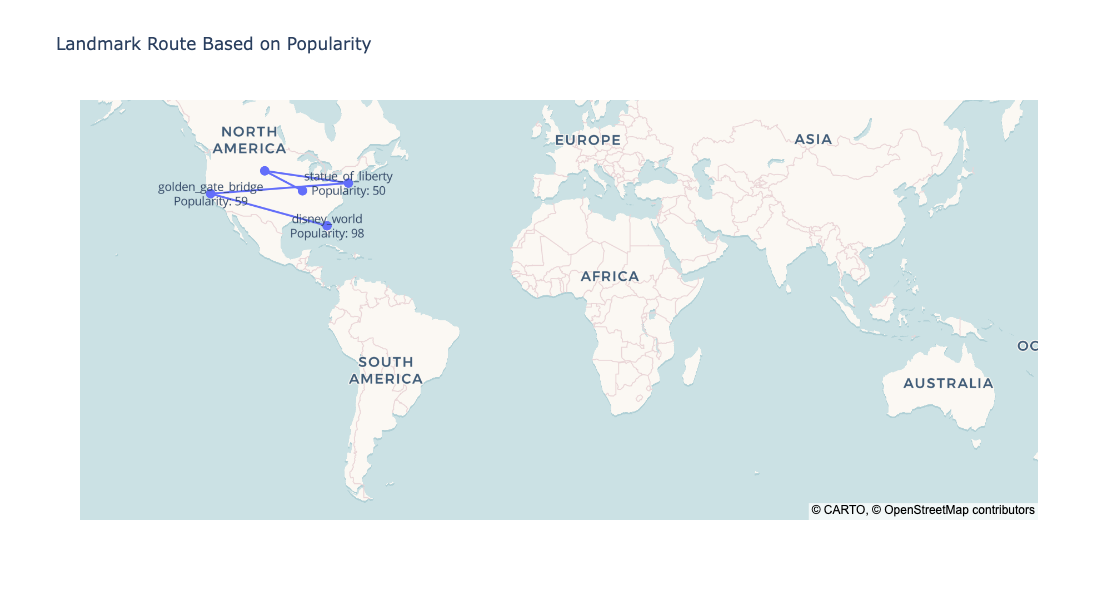

In [50]:
# Copy data 
map_df = df.copy()

# Sort based on popularity score
map_df = map_df.sort_values(by='popularity', ascending=False).reset_index(drop=True)

# Create mapbox scatter with lines
fig = go.Figure()

# Add route line to connect based off sorted popularity score
fig.add_trace(go.Scattermap(
    mode="lines+markers+text", # show lines, markers and text
    lon=map_df['longitude'], # longitude data
    lat=map_df['latitude'],  # latitude data
    text=map_df['landmark'] + '<br>Popularity: ' + map_df['popularity'].astype(str), # hover text
    marker={'size': 10}, # marker size for landmarks
    line={'width': 2}, # line width
    hoverinfo='text' # show text on hover only
))

# Map layout based on landmark coordinates
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=3,
    mapbox_center={"lat": map_df['latitude'].mean(), "lon": map_df['longitude'].mean()},
    title="Landmark Route Based on Popularity",
    height=600
)

fig.show() # show the interactive map

**Visit Time Vs. Popularity**

This plot shows the trade off between visit time and popularity.

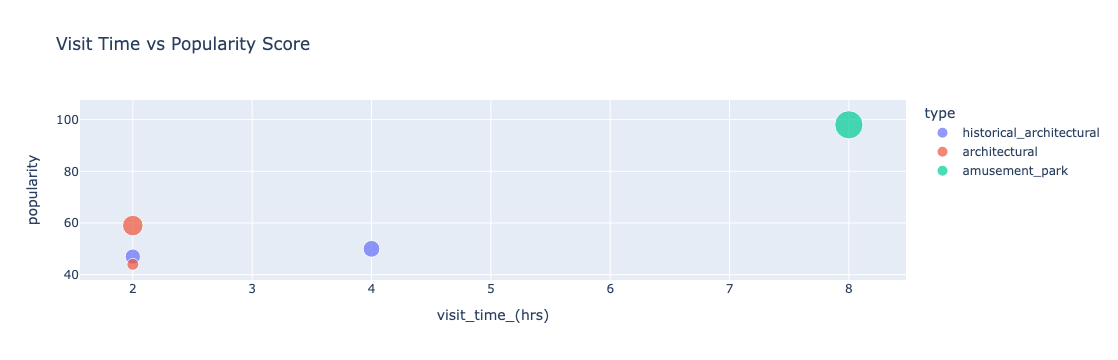

In [53]:
# Create a scatter plot to compare the relationship between visit time and popularity
fig = px.scatter(
    df,
    x='visit_time_(hrs)', # visit time on the x-axis
    y='popularity', # popularity score on the y-axis
    color='type', # color based on landmark type
    hover_name='landmark', # show landmark name on hover
    title='Visit Time vs Popularity Score', 
    size='reviews_photos', # bubble size represents number of reviews_photos
    size_max=20 # max size for the bubbles
)

fig.show()

## Modeling

**BASELINE MODEL**
-Create a first route and visualize it
-Select the next location randomly

-Each route point should be visited only once
-Compute the total distance after visiting all locations (it would allow you to evaluate the improvement of the route by your optimization model).

To calculate the shortest distance between two points on the surface of a sphere, given their latitude and longitude, we will use the haversine formula. We have incorporated the formula into our 'compute_total_distance function' for easier use in the future.

In [57]:
# Shuffle the data 
baseline_route = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [59]:
# View the baseline route
baseline_route

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50
1,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,98
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,44
3,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47
4,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59


In [61]:
# Create an empty list 
distance_list = []

# Loop through each pair of consecutive landmarks for the baseline route
for i in range(len(baseline_route) - 1):
    landmark_from = baseline_route.loc[i, 'landmark']
    landmark_to = baseline_route.loc[i + 1, 'landmark']
    
    loc1 = (baseline_route.loc[i, 'latitude'], baseline_route.loc[i, 'longitude'])
    loc2 = (baseline_route.loc[i + 1, 'latitude'], baseline_route.loc[i + 1, 'longitude'])
    
    distance_km = haversine(loc1, loc2)
    
    # Append results as a dictionary
    distance_list.append({
        'From': landmark_from,
        'To': landmark_to,
        'Distance (km)': round(distance_km, 2)
    })

# Convert the list to a DataFrame
baseline_distances_df = pd.DataFrame(distance_list)

# Display the DataFrame
baseline_distances_df

,From,To,Distance (km)
0,statue_of_liberty,disney_world,1530.22
1,disney_world,gateway_arch,1389.59
2,gateway_arch,mount_rushmore,1252.02
3,mount_rushmore,golden_gate_bridge,1730.68


<div class="alert alert-block alert-info">

since my pip thing wasn't working I made a function for distance using math so I could test it out

__Below I made a function called "best_route" that takes a starting latitude and longitude, the finds path with the shortest distance incorporating your "compute_total_distance" function. The output will display the shortest distance along with the order of the best route including the "home" location__
</div>

In [132]:
# Manual harversine function
def distance(lat1, lon1, lat2, lon2):
    lat1r = lat1*((math.pi)/180) #converts lats and lons to radians for formula
    lat2r = lat2*((math.pi)/180)
    lon1r = lon1*((math.pi)/180)
    lon2r = lon2*((math.pi)/180)
    delta_lat = lat2r - lat1r
    delta_lon = lon2r - lon1r
    R = 6378
    hav = ((math.sin((delta_lat)/2))**2) + (math.cos(lat1r))*(math.cos(lat2r))*((math.sin((delta_lon)/2))**2)
    distance = 2*R*math.asin(hav**0.5)
    return distance

In [134]:
# Made with manual harversine function
def compute_total_distance(route_df):
    total_distance = 0  #initialize total distance

    # Loop through each pair of consecutive locations in the route
    for i in range(len(route_df) - 1):
        lat1 = route_df.loc[i, 'latitude']
        lon1 = route_df.loc[i, 'longitude'] # Get the coordinates for the current location
        lat2 = route_df.loc[i+1, 'latitude']
        lon2 = route_df.loc[i+1, 'longitude'] # Get the coordinates of the next location in the route
        total_distance += distance(lat1, lon1, lat2, lon2) # Calculate the distance between loc1 and loc2 using haversine formula
    return total_distance  # Return total accumulated distance for the route

In [136]:
# Calculate distance for the random baseline route
baseline_distance = compute_total_distance(baseline_route)

print(f"Baseline Random Route Total Distance: {baseline_distance:.2f} km")

Baseline Random Route Total Distance: 5908.99 km


After your baseline model (random) is established, you need to develop an approach to optimize your route. 
- i.e., find the route with the shortest total distance.
- The total distance is the objective function, which should be minimized
- The task to find the optimal distance is a little bit different from usual ML modeling, which we talked about a lot on the platform
- To minimize the distance, you need to come up with an algorithm that selects the next location to visit in such a way that the total distance is minimized (and no location is visited twice).

After your model is created and run, please 
- Calculate the total distance for the optimized route
- Time needed to find this optimal route.
- It would be nice if both your baseline and optimized solutions were visible on the screen for comparison.

<div class="alert alert-block alert-info">

The function below take input latitude and longitude.
It will create a 1 row dataframe with the latitude and longitude in the correct locations. The other elements are filled with unimportant filler values. This represents the starting point.
A copy of that 1 row dataframe is created as well to represent the ending point.
All possible permutations of the original dataframe's index are put into a list and set to a variable.
A for loop loops through that list to create a reorganized version of the landmark dataframe. With each iteration, the dataframe is concatinated with the single row dataframes in such a fashion that its between the two single row dataframes. Once a concatinated dataframe is made and the index is reset, the total distance traveled from start to finish is calculated using the compute_total_distance function.
The total distance is then compared with the best distance with a conditional statement.
Once the shortest distance is achieved, it is recorded.
The order of the locations is appended to a neat list.
The function finally returns both the shortest distance along with the order of locations.

</div>

<div class="alert alert-block alert-warning">

__Be aware that the longitudes for American locations are "West" direction. Therefore they should be negative values__
</div>

In [174]:
# Function to calculate total distance and best route by latitude and longitude inputs
def best_route(lat, lon):
    best_dist = 1000000 #about half the earth's circumference
    best_route = None
    location_order = []
    cols = df.columns
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]]
    home = pd.DataFrame(data=fill, columns=cols)
    home2 = home.copy()
    permutations = list(itertools.permutations(df.index))
    for i, perm in enumerate(permutations):
        route = df.loc[list(perm)].reset_index(drop=True)
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True)
        dist = compute_total_distance(complete_route)
        if dist < best_dist:
            best_dist = dist
            best_route = complete_route
    for p in best_route['landmark']:
        location_order.append(p)
    return f"Total Distance: {best_dist}, Best Route {location_order}"

In [164]:
#test locations
best_route(40.0061, -83.0283) #ohio state university

"Total Distance: 9841.965626634103, Best Route ['home', 'gateway_arch', 'mount_rushmore', 'golden_gate_bridge', 'disney_world', 'statue_of_liberty', 'home']"

In [166]:
best_route(45.5152, -122.6784) #portland oregon

"Total Distance: 10493.58176190254, Best Route ['home', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'golden_gate_bridge', 'home']"

In [168]:
best_route(29.7601, -95.3701) #Houston Texas

"Total Distance: 9921.111202227685, Best Route ['home', 'golden_gate_bridge', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'home']"

In [170]:
best_route(34.0549, -118.2426) #los angeles

"Total Distance: 10013.82989959652, Best Route ['home', 'golden_gate_bridge', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'home']"

In [172]:
best_route(36.1627, -86.7816)

"Total Distance: 9912.4791512315, Best Route ['home', 'disney_world', 'statue_of_liberty', 'mount_rushmore', 'golden_gate_bridge', 'gateway_arch', 'home']"

To improve the model, we will add a geocoder converter that takes an address as input then converts it into latitude and longitude.

In [126]:
# Converts address to latitude & longitude using Geopy
def geocode_address(address):
    geolocator = Nominatim(user_agent="brute_force_route_optimizer")
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError(f"Address not found: {address}")

<div style="background-color: #d4edda; padding: 10px; border-left: 5px solid green;">

I took your function and added a geocoder that will accept an address variable as input. Then, the function will convert the address into latitude and longitude and return the optimized route and total distance.

</div>

In [194]:
# Takes address as an input and outputs total distance and the best route based off the input
def best_route1(address, df): #input of latitude and longitude coordinates

    # FIRST, Geocode the input for the address
    lat, lon = geocode_address(address) 
    
    best_dist = 1000000 #a million for comparison
    best_route = None #setting a variable for best route
    location_order = [] #blank list to append to later for neatness
    
    cols = df.columns #acquiring columns from location dataframe

    # SECOND, create dataframe row for home/starting point
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]] #list of values for dataframe creation
    home = pd.DataFrame(data=fill, columns=cols) #home dataframe
    home2 = home.copy() #copy
    
    # THIRD, check all permutations of landmark order
    permutations = list(itertools.permutations(df.index)) #all permutations of index
    
    for i, perm in enumerate(permutations): #for loop to try all permutations with home location at start and finish
        route = df.loc[list(perm)].reset_index(drop=True) #new order of df
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True) #concat
        dist = compute_total_distance(complete_route) #calc total distance
        if dist < best_dist: #check if the distance is shorter
            best_dist = dist
            best_route = complete_route
    
    # FOURTH, extract order of landmark names for display
    for p in best_route['landmark']: #appending loactions for neatness
        location_order.append(p)
    
    return f"Total Distance: {best_dist}, Best Route {location_order}"

In [190]:
# Geocoder works best with street address, city and state at a minimum
address = '1417 Columbus Drive St. Louis Mo'

result = best_route1(address, df)
print(result)

Total Distance: 9848.683985131469, Best Route ['home', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'golden_gate_bridge', 'mount_rushmore', 'home']


```python

Python code for Software Engineers;

#Takes two coordinates and finds the distance between them on earth (kilometers)
def distance(lat1, lon1, lat2, lon2):
    lat1r = lat1*((math.pi)/180) #converts lats and lons to radians for formula
    lat2r = lat2*((math.pi)/180)
    lon1r = lon1*((math.pi)/180)
    lon2r = lon2*((math.pi)/180)
    delta_lat = lat2r - lat1r
    delta_lon = lon2r - lon1r
    R = 6378
    hav = ((math.sin((delta_lat)/2))**2) + (math.cos(lat1r))*(math.cos(lat2r))*((math.sin((delta_lon)/2))**2)
    distance = 2*R*math.asin(hav**0.5)
    return distance

# Calculates total distance
def compute_total_distance(route_df):
    total_distance = 0  #initialize total distance

    # Loop through each pair of consecutive locations in the route
    for i in range(len(route_df) - 1):
        lat1 = route_df.loc[i, 'latitude']
        lon1 = route_df.loc[i, 'longitude'] # Get the coordinates for the current location
        lat2 = route_df.loc[i+1, 'latitude']
        lon2 = route_df.loc[i+1, 'longitude'] # Get the coordinates of the next location in the route
        total_distance += distance(lat1, lon1, lat2, lon2) # Calculate the distance between loc1 and loc2 using haversine formula
    return total_distance  # Return total accumulated distance for the route

# Converts address to latitude & longitude using Geopy
def geocode_address(address):
    geolocator = Nominatim(user_agent="brute_force_route_optimizer")
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError(f"Address not found: {address}")

# Takes address as an input and outputs total distance and the best route based off the input
def best_route1(address, df): # Geocoder works best with street address, city, and state at a minimum

    # FIRST, Geocode the input for the address
    lat, lon = geocode_address(address) 
    
    best_dist = 1000000 #a million for comparison
    best_route = None #setting a variable for best route
    location_order = [] #blank list to append to later for neatness
    
    cols = df.columns #acquiring columns from location dataframe

    # SECOND, create dataframe row for home/starting point
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]] #list of values for dataframe creation
    home = pd.DataFrame(data=fill, columns=cols) #home dataframe
    home2 = home.copy() #copy
    
    # THIRD, check all permutations of landmark order
    permutations = list(itertools.permutations(df.index)) #all permutations of index
    
    for i, perm in enumerate(permutations): #for loop to try all permutations with home location at start and finish
        route = df.loc[list(perm)].reset_index(drop=True) #new order of df
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True) #concat
        dist = compute_total_distance(complete_route) #calc total distance
        if dist < best_dist: #check if the distance is shorter
            best_dist = dist
            best_route = complete_route
    
    # FOURTH, extract order of landmark names for display
    for p in best_route['landmark']: #appending loactions for neatness
        location_order.append(p)
    
    return f"Total Distance: {best_dist}, Best Route {location_order}"
```

## Visualizations

The visualizations should be interactive
	- What elements will be interactive
	- How the end-user should interact with it

Visualizations you can use libraries such as plotly 
- Example: https://plotly.com/python/maps/
- More examples https://python-graph-gallery.com/
  
Visualize 
- Statistics for locations or travel times
- Include a map with locations and the optimal route on this map
- Initial and optimized total distance and time needed for the model to calculate the optimal route.

**Baseline Route Visualization**

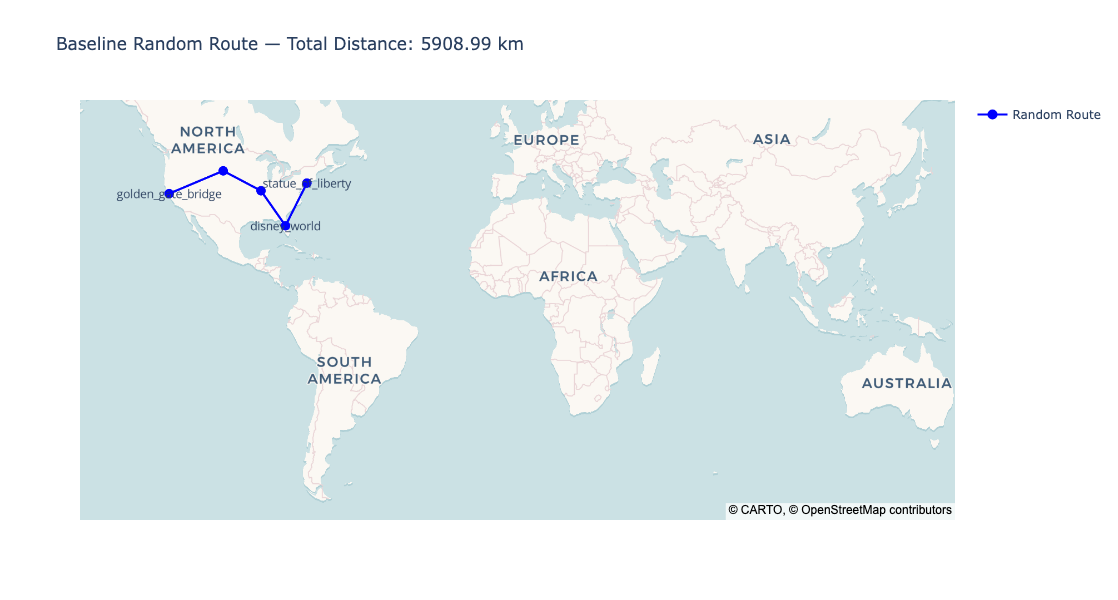

In [201]:
# Make a copy of the baseline route DataFrame 
route_map = baseline_route.copy()

# Initialize plotly figure
fig = go.Figure()

# Add a trace (layer) to the figure for the route line and markers
fig.add_trace(go.Scattermap(
    mode="lines+markers+text",  # Show lines connecting points, markers, and text labels
    lon=route_map['longitude'],  # Longitude values for the map points
    lat=route_map['latitude'],   # Latitude values for the map points
    text=route_map['landmark'],  # Landmark names appear on hover
    marker={'size': 10, 'color': 'blue'},  # Marker appearance 
    line={'width': 2, 'color': 'blue'},    # Line appearance 
    hoverinfo='text',  # Show text on hover
    name='Random Route'  # Legend name
))

# Add line segments with hover text showing the distance
for i in range(len(route_map) - 1):
    loc1 = (route_map.loc[i, 'latitude'], route_map.loc[i, 'longitude'])
    loc2 = (route_map.loc[i + 1, 'latitude'], route_map.loc[i + 1, 'longitude'])
    
    distance_km = haversine(loc1, loc2)
    
    fig.add_trace(go.Scattermap(
        mode="lines",
        lon=[loc1[1], loc2[1]],
        lat=[loc1[0], loc2[0]],
        line={'width': 2, 'color': 'blue'},
        text=[f"{route_map.loc[i, 'landmark']} → {route_map.loc[i + 1, 'landmark']}<br>Distance: {distance_km:.2f} km"],
        hoverinfo='text',
        showlegend=False
    ))

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",  # The base map style
    mapbox_zoom=3,  # Set initial zoom level
    mapbox_center={  # Center the map based on average of all latitudes and longitudes
        "lat": route_map['latitude'].mean(),
        "lon": route_map['longitude'].mean()
    },
    title=f"Baseline Random Route — Total Distance: {baseline_distance:.2f} km",  # Title includes total distance
    height=600  # Set figure height
)

# Display the interactive map
fig.show()

In [205]:
def best_route3(lat, lon):
    best_dist = 1000000 #about half the earth's circumference
    best_route = None
    location_order = []
    cols = df.columns
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]]
    home = pd.DataFrame(data=fill, columns=cols)
    home2 = home.copy()
    permutations = list(itertools.permutations(df.index))
    for i, perm in enumerate(permutations):
        route = df.loc[list(perm)].reset_index(drop=True)
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True)
        dist = compute_total_distance(complete_route)
        if dist < best_dist:
            best_dist = dist
            best_route = complete_route
    return best_route

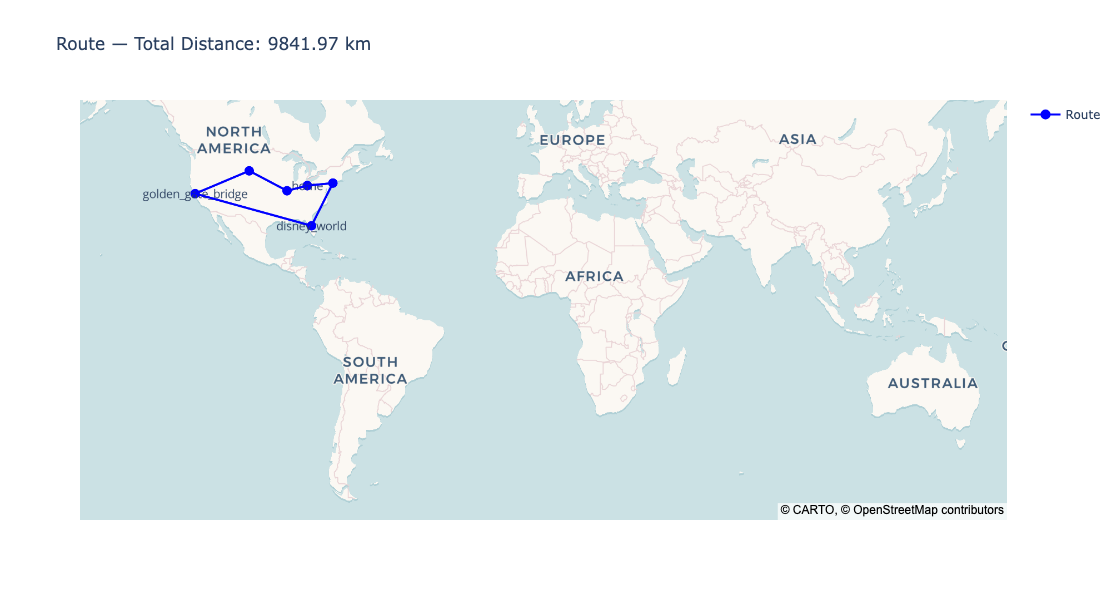

In [209]:
route_map = best_route3(40.0061, -83.0283)

# Initialize plotly figure
fig = go.Figure()

# Add a trace (layer) to the figure for the route line and markers
fig.add_trace(go.Scattermap(
    mode="lines+markers+text",  # Show lines connecting points, markers, and text labels
    lon=route_map['longitude'],  # Longitude values for the map points
    lat=route_map['latitude'],   # Latitude values for the map points
    text=route_map['landmark'],  # Landmark names appear on hover
    marker={'size': 10, 'color': 'blue'},  # Marker appearance 
    line={'width': 2, 'color': 'blue'},    # Line appearance 
    hoverinfo='text',  # Show text on hover
    name='Route'  # Legend name
))

# Add line segments with hover text showing the distance
for i in range(len(route_map) - 1):
    lat1 = route_map.loc[i, 'latitude']
    lon1 = route_map.loc[i, 'longitude'] 
    lat2 = route_map.loc[i+1, 'latitude']
    lon2 = route_map.loc[i+1, 'longitude']
    
    distance_km = compute_total_distance2(route_map)
    
    fig.add_trace(go.Scattermap(
        mode="lines",
        lon=[lon1, lon2],
        lat=[lat1, lat2],
        line={'width': 2, 'color': 'blue'},
        text=[f"{route_map.loc[i, 'landmark']} → {route_map.loc[i + 1, 'landmark']}<br>Distance: {distance_km:.2f} km"],
        hoverinfo='text',
        showlegend=False
    ))

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",  # The base map style
    mapbox_zoom=3,  # Set initial zoom level
    mapbox_center={  # Center the map based on average of all latitudes and longitudes
        "lat": route_map['latitude'].mean(),
        "lon": route_map['longitude'].mean()
    },
    title=f"Route — Total Distance: {distance_km:.2f} km",  # Title includes total distance
    height=600  # Set figure height
)

# Display the interactive map
fig.show()

geocoder (best_route1) needs to be a dataframe

In [ ]:
route_map = best_route1(address, df)

# Initialize plotly figure
fig = go.Figure()

# Add a trace (layer) to the figure for the route line and markers
fig.add_trace(go.Scattermap(
    mode="lines+markers+text",  # Show lines connecting points, markers, and text labels
    lon=route_map['longitude'],  # Longitude values for the map points
    lat=route_map['latitude'],   # Latitude values for the map points
    text=route_map['landmark'],  # Landmark names appear on hover
    marker={'size': 10, 'color': 'blue'},  # Marker appearance 
    line={'width': 2, 'color': 'blue'},    # Line appearance 
    hoverinfo='text',  # Show text on hover
    name='Route'  # Legend name
))

# Add line segments with hover text showing the distance
for i in range(len(route_map) - 1):
    lat1 = route_map.loc[i, 'latitude']
    lon1 = route_map.loc[i, 'longitude'] 
    lat2 = route_map.loc[i+1, 'latitude']
    lon2 = route_map.loc[i+1, 'longitude']
    
    distance_km = compute_total_distance2(route_map)
    
    fig.add_trace(go.Scattermap(
        mode="lines",
        lon=[lon1, lon2],
        lat=[lat1, lat2],
        line={'width': 2, 'color': 'blue'},
        text=[f"{route_map.loc[i, 'landmark']} → {route_map.loc[i + 1, 'landmark']}<br>Distance: {distance_km:.2f} km"],
        hoverinfo='text',
        showlegend=False
    ))

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",  # The base map style
    mapbox_zoom=3,  # Set initial zoom level
    mapbox_center={  # Center the map based on average of all latitudes and longitudes
        "lat": route_map['latitude'].mean(),
        "lon": route_map['longitude'].mean()
    },
    title=f"Route — Total Distance: {distance_km:.2f} km",  # Title includes total distance
    height=600  # Set figure height
)

# Display the interactive map
fig.show()

## Conclusion